In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet50

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import random
from tqdm import tqdm
import pickle

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Training EEG-to-Image GAN with your dataset...
Dataset: 45390 EEG samples, 898 images
Classes: 10
EEG shape: (45390, 14, 32, 1)
EEG labels shape: (45390, 10)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 214MB/s]


Starting training with contrastive learning...


Epoch 1/10: 100%|██████████| 1419/1419 [19:50<00:00,  1.19it/s, Cont_Loss=3.9701, G_Loss=2.9741, D_Loss=0.8848]


Epoch 1: Contrastive_Loss = 3.9701, G_Loss = 2.9741, D_Loss = 0.8848


Epoch 2/10: 100%|██████████| 1419/1419 [19:59<00:00,  1.18it/s, Cont_Loss=3.9666, G_Loss=3.4955, D_Loss=0.7535]


Epoch 2: Contrastive_Loss = 3.9666, G_Loss = 3.4955, D_Loss = 0.7535


Epoch 3/10: 100%|██████████| 1419/1419 [20:01<00:00,  1.18it/s, Cont_Loss=3.9666, G_Loss=4.1804, D_Loss=0.5959]


Epoch 3: Contrastive_Loss = 3.9666, G_Loss = 4.1804, D_Loss = 0.5959


Epoch 4/10: 100%|██████████| 1419/1419 [19:59<00:00,  1.18it/s, Cont_Loss=3.9660, G_Loss=4.8001, D_Loss=0.4920]


Epoch 4: Contrastive_Loss = 3.9660, G_Loss = 4.8001, D_Loss = 0.4920


Epoch 5/10: 100%|██████████| 1419/1419 [19:55<00:00,  1.19it/s, Cont_Loss=3.9661, G_Loss=5.6938, D_Loss=0.3698]


Epoch 5: Contrastive_Loss = 3.9661, G_Loss = 5.6938, D_Loss = 0.3698


Epoch 6/10: 100%|██████████| 1419/1419 [19:56<00:00,  1.19it/s, Cont_Loss=3.9658, G_Loss=6.3124, D_Loss=0.3137]


Epoch 6: Contrastive_Loss = 3.9658, G_Loss = 6.3124, D_Loss = 0.3137


Epoch 7/10: 100%|██████████| 1419/1419 [19:55<00:00,  1.19it/s, Cont_Loss=3.9661, G_Loss=6.7179, D_Loss=0.2867]


Epoch 7: Contrastive_Loss = 3.9661, G_Loss = 6.7179, D_Loss = 0.2867


Epoch 8/10: 100%|██████████| 1419/1419 [19:54<00:00,  1.19it/s, Cont_Loss=3.9659, G_Loss=7.1702, D_Loss=0.2395]


Epoch 8: Contrastive_Loss = 3.9659, G_Loss = 7.1702, D_Loss = 0.2395


Epoch 9/10: 100%|██████████| 1419/1419 [19:54<00:00,  1.19it/s, Cont_Loss=3.9656, G_Loss=7.5048, D_Loss=0.2227]


Epoch 9: Contrastive_Loss = 3.9656, G_Loss = 7.5048, D_Loss = 0.2227


Epoch 10/10: 100%|██████████| 1419/1419 [19:53<00:00,  1.19it/s, Cont_Loss=3.9655, G_Loss=7.7831, D_Loss=0.2011]


Epoch 10: Contrastive_Loss = 3.9655, G_Loss = 7.7831, D_Loss = 0.2011


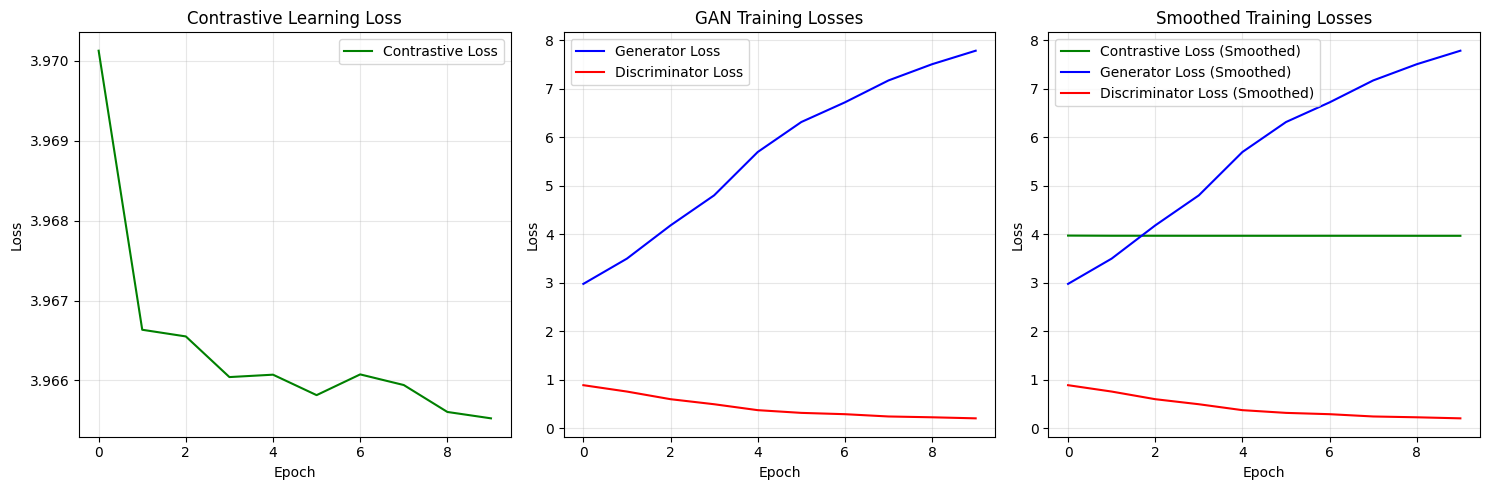

Training history saved as training_history.png
Dataset: 45390 EEG samples, 898 images
Classes: 10
EEG shape: (45390, 14, 32, 1)
EEG labels shape: (45390, 10)


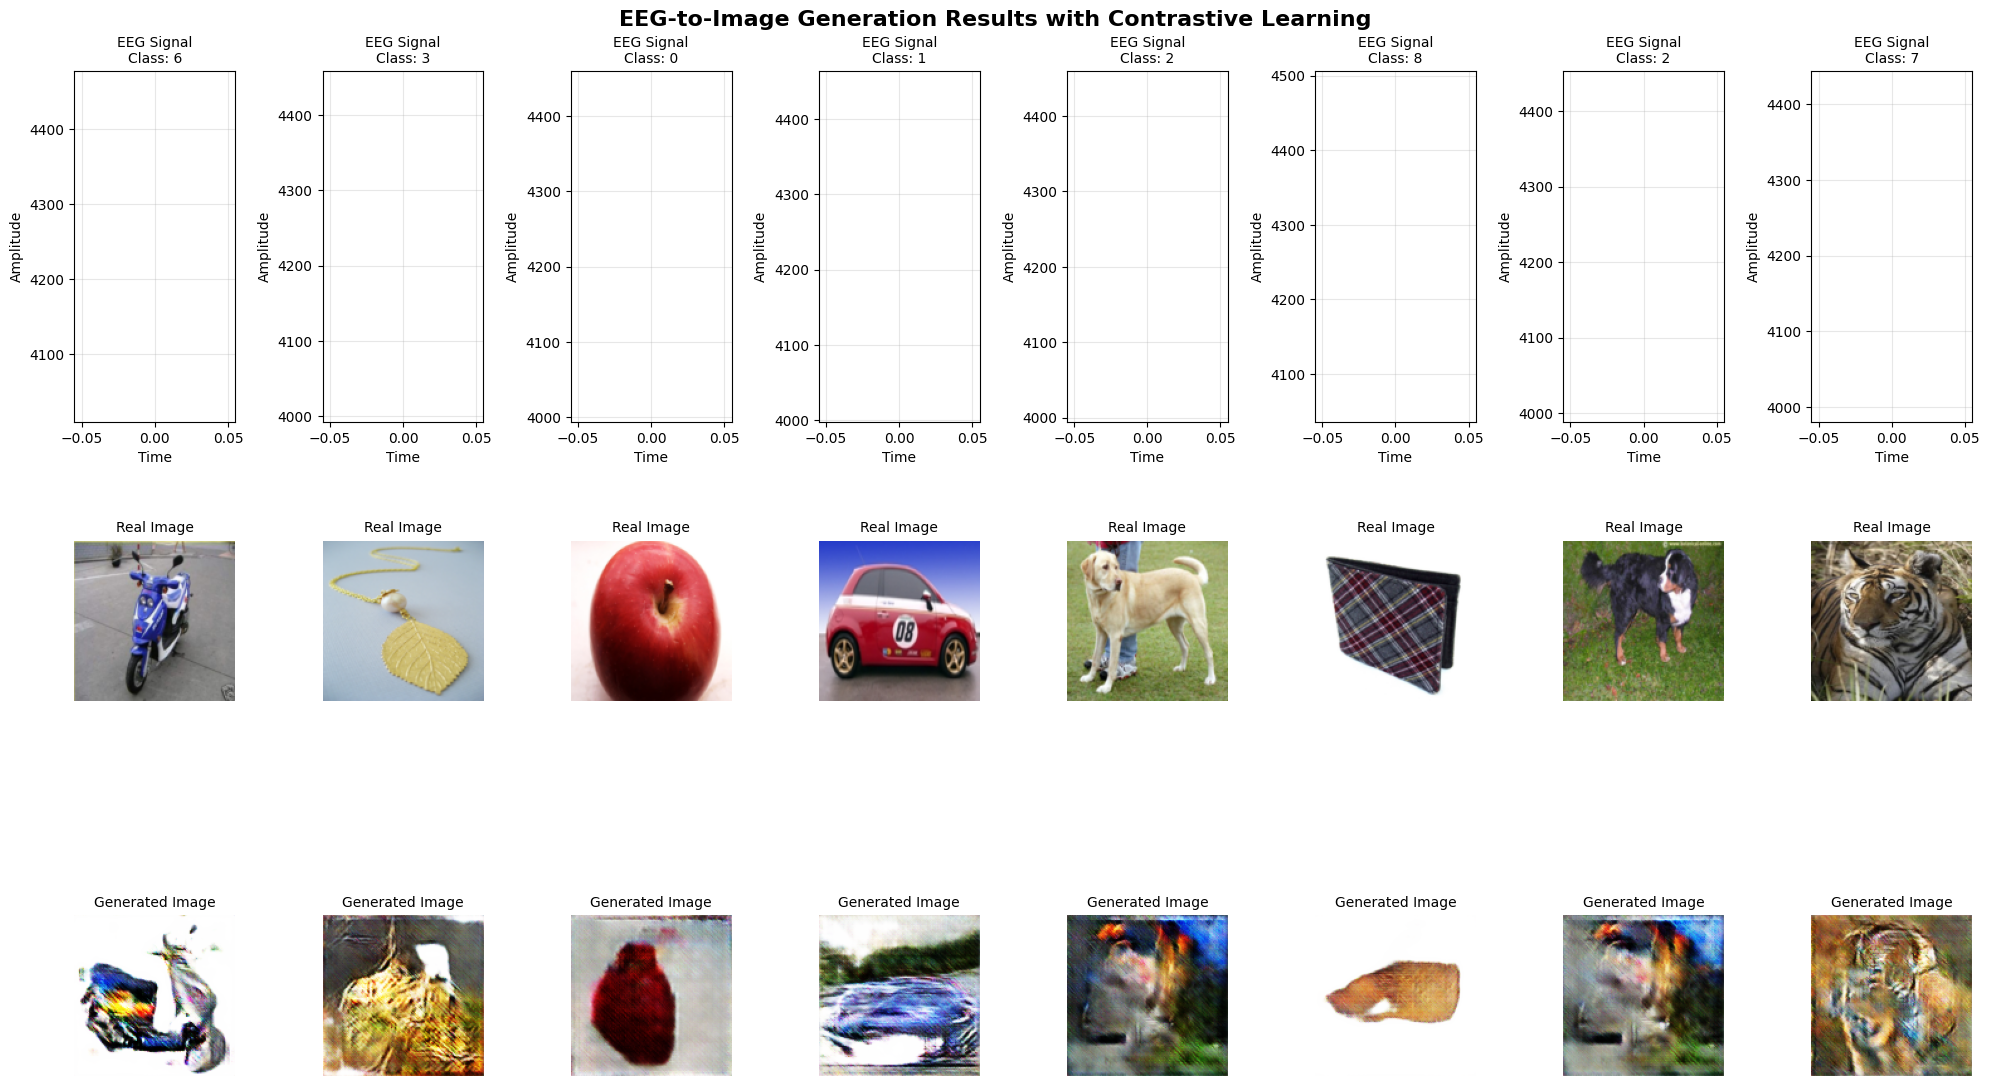

Visualization saved as generated_samples.png


NameError: name 'dsjdjn' is not defined

In [2]:
class SpectralNorm(nn.Module):
    """Spectral Normalization wrapper"""
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            v.data = F.normalize(torch.mv(torch.t(w.view(height, -1).data), u.data), dim=0)
            u.data = F.normalize(torch.mv(w.view(height, -1).data, v.data), dim=0)

        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _made_params(self):
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False

    def _make_params(self):
        w = getattr(self.module, self.name)
        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = nn.Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = nn.Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        u.data = F.normalize(u.data, dim=0)
        v.data = F.normalize(v.data, dim=0)
        w_bar = nn.Parameter(w.data)

        del self.module._parameters[self.name]
        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)

    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)

def spectral_norm(module, name='weight', power_iterations=1):
    return SpectralNorm(module, name, power_iterations)

# Image Encoder for Contrastive Learning
class ImageEncoder(nn.Module):
    """Encode images to latent features for contrastive learning"""
    def __init__(self, latent_dim=512):
        super(ImageEncoder, self).__init__()
        
        # Use pretrained ResNet50 as backbone
        resnet = resnet50(pretrained=True)
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])  # Remove final FC layer
        
        # Projection head for contrastive learning
        self.projection_head = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, latent_dim)
        )
        
        # Freeze early layers of ResNet
        for param in list(self.backbone.parameters())[:-20]:
            param.requires_grad = False
    
    def forward(self, x):
        # x shape: (batch_size, 3, 128, 128)
        features = self.backbone(x)
        features = features.view(features.size(0), -1)  # Flatten
        projected = self.projection_head(features)
        return F.normalize(projected, dim=1)  # L2 normalize for contrastive learning


class EEGEncoder(nn.Module):
    """Modified EEG Encoder for shape (batch, 14, 32, 1)"""
    def __init__(self, input_channels=14, sequence_length=32, latent_dim=512):
        super(EEGEncoder, self).__init__()
        
        # Conv1D layers for channel processing
        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        
        # LSTM layers for temporal processing
        self.lstm1 = nn.LSTM(256, 128, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(256, 64, batch_first=True, bidirectional=True)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * sequence_length, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, latent_dim)
        
        # Projection head for contrastive learning
        self.contrastive_head = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, latent_dim)
        )
        
        self.dropout = nn.Dropout(0.3)
        self.leaky_relu = nn.LeakyReLU(0.2)
        
    def forward(self, x, return_contrastive=False):
        # x shape: (batch_size, 14, 32, 1) -> (batch_size, 14, 32)
        x = x.squeeze(-1)  # Remove the last dimension
        
        # Apply 1D convolutions along the time dimension
        x = self.leaky_relu(self.conv1(x))  # (batch, 64, 32)
        x = self.dropout(x)
        x = self.leaky_relu(self.conv2(x))  # (batch, 128, 32)
        x = self.dropout(x)
        x = self.leaky_relu(self.conv3(x))  # (batch, 256, 32)
        
        # Transpose for LSTM: (batch, seq_len, features)
        x = x.transpose(1, 2)  # (batch, 32, 256)
        
        # LSTM processing
        x, _ = self.lstm1(x)
        x = self.dropout(x)
        x, _ = self.lstm2(x)
        
        # Flatten and process through FC layers
        x = x.flatten(1)
        x = self.leaky_relu(self.fc1(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.fc2(x))
        x = self.dropout(x)
        features = self.fc3(x)
        
        if return_contrastive:
            # Return both generator features and contrastive features
            contrastive_features = self.contrastive_head(features)
            contrastive_features = F.normalize(contrastive_features, dim=1)
            return features, contrastive_features
        
        return features

class Generator(nn.Module):
    """Modified Generator for 10 classes"""
    def __init__(self, eeg_dim=512, noise_dim=100, n_classes=10):
        super(Generator, self).__init__()
        
        # Class embedding
        self.class_embedding = nn.Embedding(n_classes, 50)
        
        # Combine EEG features, noise, and class
        input_dim = eeg_dim + noise_dim + 50
        
        # Initial projection
        self.fc = nn.Linear(input_dim, 8 * 8 * 1024)
        
        # Transposed convolution layers
        self.convt1 = spectral_norm(nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False))
        self.bn1 = nn.BatchNorm2d(512)
        
        self.convt2 = spectral_norm(nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False))
        self.bn2 = nn.BatchNorm2d(256)
        
        self.convt3 = spectral_norm(nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False))
        self.bn3 = nn.BatchNorm2d(128)
        
        self.convt4 = spectral_norm(nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False))
        self.bn4 = nn.BatchNorm2d(64)
        
        self.convt5 = spectral_norm(nn.ConvTranspose2d(64, 3, 3, 1, 1, bias=False))
        
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.tanh = nn.Tanh()
        
    def forward(self, eeg_features, noise, class_labels):
        # Embed class labels
        class_emb = self.class_embedding(class_labels)
        
        # Combine all inputs
        x = torch.cat([eeg_features, noise, class_emb], dim=1)
        
        # Initial projection and reshape
        x = self.fc(x)
        x = x.view(-1, 1024, 8, 8)
        
        # Transposed convolutions with batch norm and activation
        x = self.leaky_relu(self.bn1(self.convt1(x)))  # 16x16
        x = self.leaky_relu(self.bn2(self.convt2(x)))  # 32x32
        x = self.leaky_relu(self.bn3(self.convt3(x)))  # 64x64
        x = self.leaky_relu(self.bn4(self.convt4(x)))  # 128x128
        x = self.tanh(self.convt5(x))                   # 128x128x3
        
        return x

class Discriminator(nn.Module):
    """Modified Discriminator for 10 classes"""
    def __init__(self, n_classes=10):
        super(Discriminator, self).__init__()
        
        # Class embedding
        self.class_embedding = nn.Embedding(n_classes, 50)
        self.class_projection = nn.Linear(50, 128 * 128)
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(4, 64, 3, 2, 1, bias=False)  # 4 channels (3 RGB + 1 class)
        self.conv2 = nn.Conv2d(64, 128, 3, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, 3, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(256)
        
        self.conv4 = nn.Conv2d(256, 512, 3, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(512)
        
        self.conv5 = nn.Conv2d(512, 1024, 3, 1, 1, bias=False)
        self.bn5 = nn.BatchNorm2d(1024)
        
        self.conv6 = nn.Conv2d(1024, 1, 3, 1, 1, bias=False)
        
        self.leaky_relu = nn.LeakyReLU(0.2)
        
    def forward(self, x, class_labels):
        batch_size = x.size(0)
        
        # Embed and project class labels
        class_emb = self.class_embedding(class_labels)
        class_map = self.class_projection(class_emb)
        class_map = class_map.view(batch_size, 1, 128, 128)
        
        # Concatenate image with class map
        x = torch.cat([x, class_map], dim=1)
        
        # Convolutional layers
        x = self.leaky_relu(self.conv1(x))
        x = self.leaky_relu(self.bn2(self.conv2(x)))
        x = self.leaky_relu(self.bn3(self.conv3(x)))
        x = self.leaky_relu(self.bn4(self.conv4(x)))
        x = self.leaky_relu(self.bn5(self.conv5(x)))
        x = self.conv6(x)
        
        return x.view(batch_size, -1).mean(dim=1)

# Contrastive Loss Functions
def info_nce_loss(eeg_features, img_features, temperature=0.07):
    """
    InfoNCE loss for contrastive learning
    """
    batch_size = eeg_features.size(0)
    
    # Compute similarity matrix
    similarity_matrix = torch.matmul(eeg_features, img_features.T) / temperature
    
    # Labels for positive pairs (diagonal elements)
    labels = torch.arange(batch_size).to(eeg_features.device)
    
    # Compute InfoNCE loss
    loss = F.cross_entropy(similarity_matrix, labels)
    
    return loss

def triplet_loss(anchor, positive, negative, margin=1.0):
    """
    Triplet loss for contrastive learning
    """
    pos_dist = F.pairwise_distance(anchor, positive)
    neg_dist = F.pairwise_distance(anchor, negative)
    
    loss = F.relu(pos_dist - neg_dist + margin)
    return loss.mean()

class EEGImageDataset(Dataset):
    """Modified Dataset for your pickle file and 10-class structure"""
    def __init__(self, eeg_pickle_path, images_dir, transform=None):
        # Load EEG data from pickle file
        with open(eeg_pickle_path, 'rb') as f:
            data_dict = pickle.load(f, encoding='latin1')
        
        self.eeg_data = data_dict['x_train']  # Shape: (45390, 14, 32, 1)
        self.eeg_labels = data_dict['y_train']  # Shape: (45390, 10) - one-hot encoded
        
        # Convert one-hot labels to class indices
        self.class_labels = np.argmax(self.eeg_labels, axis=1)
        
        # Load image paths and create mapping
        self.images_dir = Path(images_dir)
        self.class_dirs = sorted([d for d in self.images_dir.iterdir() if d.is_dir()])
        self.class_to_idx = {d.name: i for i, d in enumerate(self.class_dirs)}
        
        # Create image paths list
        self.image_paths = []
        self.image_labels = []
        
        for class_idx, class_dir in enumerate(self.class_dirs):
            image_files = list(class_dir.glob('*.jpg')) + list(class_dir.glob('*.JPEG')) + list(class_dir.glob('*.jpeg'))
            for img_path in image_files:
                self.image_paths.append(img_path)
                self.image_labels.append(class_idx)
        
        # Group images by class for contrastive learning
        self.class_to_images = {}
        for i, label in enumerate(self.image_labels):
            if label not in self.class_to_images:
                self.class_to_images[label] = []
            self.class_to_images[label].append(i)
        
        self.transform = transform or transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])
        
        print(f"Dataset: {len(self.eeg_data)} EEG samples, {len(self.image_paths)} images")
        print(f"Classes: {len(self.class_dirs)}")
        print(f"EEG shape: {self.eeg_data.shape}")
        print(f"EEG labels shape: {self.eeg_labels.shape}")
        
    def __len__(self):
        return len(self.eeg_data)
    
    def __getitem__(self, idx):
        # Get EEG data and its class
        eeg = torch.FloatTensor(self.eeg_data[idx])  # Shape: (14, 32, 1)
        eeg_class = self.class_labels[idx]
        
        # Get corresponding image from the same class
        if eeg_class in self.class_to_images and len(self.class_to_images[eeg_class]) > 0:
            img_idx = random.choice(self.class_to_images[eeg_class])
        else:
            # Fallback to random image if no images for this class
            img_idx = random.randint(0, len(self.image_paths) - 1)
            
        img_path = self.image_paths[img_idx]
        img_class = self.image_labels[img_idx]
        
        # Load and transform image
        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)
        
        # For contrastive learning, get a negative sample
        available_classes = [c for c in self.class_to_images.keys() if c != img_class and len(self.class_to_images[c]) > 0]
        if available_classes:
            negative_class = random.choice(available_classes)
            negative_img_idx = random.choice(self.class_to_images[negative_class])
            negative_img_path = self.image_paths[negative_img_idx]
            negative_image = Image.open(negative_img_path).convert('RGB')
            negative_image = self.transform(negative_image)
        else:
            # Fallback: use a random different image
            negative_img_idx = random.choice([i for i in range(len(self.image_paths)) if self.image_labels[i] != img_class])
            negative_img_path = self.image_paths[negative_img_idx]
            negative_image = Image.open(negative_img_path).convert('RGB')
            negative_image = self.transform(negative_image)
        
        return eeg, image, negative_image, torch.LongTensor([img_class])

def load_test_data(eeg_pickle_path):
    """Load test data separately"""
    with open(eeg_pickle_path, 'rb') as f:
        data_dict = pickle.load(f, encoding='latin1')
    
    x_test = data_dict['x_test']  # Shape: (5706, 14, 32, 1)
    y_test = data_dict['y_test']  # Shape: (5706, 10)
    test_class_labels = np.argmax(y_test, axis=1)
    
    return x_test, test_class_labels
# Loss functions
def discriminator_hinge_loss(real_output, fake_output):
    real_loss = torch.mean(F.relu(1.0 - real_output))
    fake_loss = torch.mean(F.relu(1.0 + fake_output))
    return (real_loss + fake_loss) / 2.0

def generator_hinge_loss(fake_output):
    return -torch.mean(fake_output)

def diff_augment(x, policy="color,translation"):
    """Simple data augmentation"""
    if "color" in policy:
        # Color jittering
        x = x + torch.randn_like(x) * 0.1
        x = torch.clamp(x, -1, 1)
    
    if "translation" in policy:
        # Random translation
        if random.random() > 0.5:
            shift = random.randint(-4, 4)
            x = torch.roll(x, shift, dims=2)
            x = torch.roll(x, shift, dims=3)
    
    return x

# Modified training function with contrastive learning
def train_gan_with_contrastive_modified(eeg_pickle_path, images_dir, num_epochs=100, batch_size=32, lr=0.0002):
    # Create dataset and dataloader
    dataset = EEGImageDataset(eeg_pickle_path, images_dir)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    
    # Initialize models with correct number of classes
    eeg_encoder = EEGEncoder(input_channels=14, sequence_length=32).to(device)
    image_encoder = ImageEncoder().to(device)
    generator = Generator(n_classes=10).to(device)  # 10 classes
    discriminator = Discriminator(n_classes=10).to(device) 
    
    # Optimizers
    contrastive_optimizer = optim.Adam(
        list(eeg_encoder.parameters()) + list(image_encoder.parameters()), 
        lr=lr, betas=(0.9, 0.999)
    )
    g_optimizer = optim.Adam(
        list(eeg_encoder.parameters()) + list(generator.parameters()), 
        lr=lr, betas=(0.0, 0.9)
    )
    d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.0, 0.9))
    
    # Training tracking
    contrastive_losses = []
    g_losses = []
    d_losses = []
    
    print("Starting training with contrastive learning...")
    
    for epoch in range(num_epochs):
        contrastive_loss_total = 0
        g_loss_total = 0
        d_loss_total = 0
        
        pbar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}')
        
        for batch_idx, (eeg_batch, real_images, negative_images, class_labels) in enumerate(pbar):
            batch_size_actual = eeg_batch.size(0)
            
            eeg_batch = eeg_batch.to(device)
            real_images = real_images.to(device)
            negative_images = negative_images.to(device)
            class_labels = class_labels.squeeze().to(device)
            
            # =============== Contrastive Learning Phase ===============
            contrastive_optimizer.zero_grad()
            
            # Get features for contrastive learning
            _, eeg_contrastive_features = eeg_encoder(eeg_batch, return_contrastive=True)
            img_contrastive_features = image_encoder(real_images)
            negative_img_features = image_encoder(negative_images)
            
            # Compute contrastive losses
            info_nce = info_nce_loss(eeg_contrastive_features, img_contrastive_features)
            triplet = triplet_loss(eeg_contrastive_features, img_contrastive_features, negative_img_features)
            
            contrastive_loss = info_nce + 0.5 * triplet
            contrastive_loss.backward()
            contrastive_optimizer.step()
            
            # =============== GAN Training Phase ===============
            # Generate noise
            noise = torch.randn(batch_size_actual, 100).to(device)
            
            # Train Discriminator
            d_optimizer.zero_grad()
            
            # Encode EEG to features (detach to prevent gradients from flowing to contrastive learning)
            eeg_features = eeg_encoder(eeg_batch).detach()
            
            # Generate fake images
            fake_images = generator(eeg_features, noise, class_labels)
            
            # Apply data augmentation
            real_images_aug = diff_augment(real_images)
            fake_images_aug = diff_augment(fake_images.detach())
            
            # Discriminator predictions
            real_output = discriminator(real_images_aug, class_labels)
            fake_output = discriminator(fake_images_aug, class_labels)
            
            # Discriminator loss
            d_loss = discriminator_hinge_loss(real_output, fake_output)
            d_loss.backward()
            d_optimizer.step()
            
            # Train Generator
            g_optimizer.zero_grad()
            
            # Generate new fake images for generator training
            noise2 = torch.randn(batch_size_actual, 100).to(device)
            eeg_features = eeg_encoder(eeg_batch)
            fake_images = generator(eeg_features, noise, class_labels)
            fake_images2 = generator(eeg_features, noise2, class_labels)
            
            # Apply augmentation
            fake_images_aug = diff_augment(fake_images)
            fake_images2_aug = diff_augment(fake_images2)
            
            # Discriminator predictions on fake images
            fake_output = discriminator(fake_images_aug, class_labels)
            fake_output2 = discriminator(fake_images2_aug, class_labels)
            
            # Generator loss with mode collapse prevention
            g_loss = generator_hinge_loss(fake_output) + generator_hinge_loss(fake_output2)
            
            # Mode seeking loss
            mode_loss = torch.mean(torch.abs(fake_images2 - fake_images)) / (
                torch.mean(torch.abs(noise2 - noise)) + 1e-5)
            mode_loss = 1.0 / (mode_loss + 1e-5)
            
            # Feature alignment loss (align generated features with image features)
            with torch.no_grad():
                real_img_features = image_encoder(real_images)
            fake_img_features = image_encoder(fake_images)
            alignment_loss = F.mse_loss(fake_img_features, real_img_features)
            
            total_g_loss = g_loss + 1.0 * mode_loss + 0.1 * alignment_loss
            total_g_loss.backward()
            g_optimizer.step()
            
            # Update tracking
            contrastive_loss_total += contrastive_loss.item()
            g_loss_total += total_g_loss.item()
            d_loss_total += d_loss.item()
            
            pbar.set_postfix({
                'Cont_Loss': f'{contrastive_loss_total/(batch_idx+1):.4f}',
                'G_Loss': f'{g_loss_total/(batch_idx+1):.4f}',
                'D_Loss': f'{d_loss_total/(batch_idx+1):.4f}'
            })
        
        # Save sample images every 10 epochs
        if (epoch + 1) % 10 == 0:
            with torch.no_grad():
                sample_eeg = eeg_batch[:8]
                sample_noise = torch.randn(8, 100).to(device)
                sample_classes = class_labels[:8]
                sample_features = eeg_encoder(sample_eeg)
                sample_images = generator(sample_features, sample_noise, sample_classes)
                
                # Save sample images
                plt.figure(figsize=(12, 8))
                for i in range(8):
                    plt.subplot(2, 4, i+1)
                    img = sample_images[i].cpu()
                    img = (img + 1) / 2  # Denormalize
                    img = torch.clamp(img, 0, 1)
                    plt.imshow(img.permute(1, 2, 0))
                    plt.axis('off')
                    plt.title(f'Class: {sample_classes[i].item()}')
                
                plt.tight_layout()
                plt.savefig(f'generated_samples_epoch_{epoch+1}.png')
                plt.close()
        
        # Store epoch losses
        contrastive_losses.append(contrastive_loss_total/len(dataloader))
        g_losses.append(g_loss_total/len(dataloader))
        d_losses.append(d_loss_total/len(dataloader))
        
        print(f'Epoch {epoch+1}: Contrastive_Loss = {contrastive_loss_total/len(dataloader):.4f}, '
              f'G_Loss = {g_loss_total/len(dataloader):.4f}, '
              f'D_Loss = {d_loss_total/len(dataloader):.4f}')
    
    # Plot training history
    plot_training_history_with_contrastive(contrastive_losses, g_losses, d_losses)
    
    return eeg_encoder, image_encoder, generator, discriminator

def visualize_generated_samples(eeg_encoder, generator, dataset, num_samples=8, save_path='generated_samples.png'):
    """
    Visualize generated images from EEG signals alongside real images
    """
    eeg_encoder.eval()
    generator.eval()
    
    # Get random samples from dataset
    indices = random.sample(range(len(dataset)), num_samples)
    
    fig, axes = plt.subplots(3, num_samples, figsize=(20, 12))
    fig.suptitle('EEG-to-Image Generation Results with Contrastive Learning', fontsize=16, fontweight='bold')
    
    with torch.no_grad():
        for i, idx in enumerate(indices):
            eeg_sample, real_image, _, class_label = dataset[idx]
            
            # Prepare inputs
            eeg_batch = eeg_sample.unsqueeze(0).to(device)
            class_batch = class_label.to(device)
            noise = torch.randn(1, 100).to(device)
            
            # Generate image
            eeg_features = eeg_encoder(eeg_batch)
            generated_image = generator(eeg_features, noise, class_batch)
            
            # Convert tensors to displayable format
            real_img = (real_image + 1) / 2  # Denormalize from [-1, 1] to [0, 1]
            real_img = torch.clamp(real_img, 0, 1)
            
            gen_img = (generated_image.squeeze().cpu() + 1) / 2
            gen_img = torch.clamp(gen_img, 0, 1)
            
            # Display EEG signal (average across channels for visualization)
            eeg_plot = eeg_sample.mean(dim=0).mean(dim=0).numpy()  # Average across trials and channels
            
            # Plot EEG signal
            axes[0, i].plot(eeg_plot)
            axes[0, i].set_title(f'EEG Signal\nClass: {class_label.item()}', fontsize=10)
            axes[0, i].set_xlabel('Time')
            axes[0, i].set_ylabel('Amplitude')
            axes[0, i].grid(True, alpha=0.3)
            
            # Plot real image
            axes[1, i].imshow(real_img.permute(1, 2, 0))
            axes[1, i].set_title('Real Image', fontsize=10)
            axes[1, i].axis('off')
            
            # Plot generated image
            axes[2, i].imshow(gen_img.permute(1, 2, 0))
            axes[2, i].set_title('Generated Image', fontsize=10)
            axes[2, i].axis('off')
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Visualization saved as {save_path}")

def plot_training_history_with_contrastive(contrastive_losses, g_losses, d_losses, save_path='training_history.png'):
    """
    Plot training loss history including contrastive loss
    """
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(contrastive_losses, label='Contrastive Loss', color='green')
    plt.title('Contrastive Learning Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 2)
    plt.plot(g_losses, label='Generator Loss', color='blue')
    plt.plot(d_losses, label='Discriminator Loss', color='red')
    plt.title('GAN Training Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 3)
    # Smooth the curves using moving average
    window = max(1, len(g_losses) // 20)
    cont_smooth = np.convolve(contrastive_losses, np.ones(window)/window, mode='valid')
    g_smooth = np.convolve(g_losses, np.ones(window)/window, mode='valid')
    d_smooth = np.convolve(d_losses, np.ones(window)/window, mode='valid')
    
    plt.plot(cont_smooth, label='Contrastive Loss (Smoothed)', color='green')
    plt.plot(g_smooth, label='Generator Loss (Smoothed)', color='blue')
    plt.plot(d_smooth, label='Discriminator Loss (Smoothed)', color='red')
    plt.title('Smoothed Training Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Training history saved as {save_path}")

def evaluate_contrastive_alignment(eeg_encoder, image_encoder, dataset, num_samples=100):
    """
    Evaluate how well EEG features align with image features
    """
    eeg_encoder.eval()
    image_encoder.eval()
    
    similarities = []
    
    with torch.no_grad():
        for i in range(min(num_samples, len(dataset))):
            eeg_sample, real_image, _, class_label = dataset[i]
            
            # Get features
            eeg_batch = eeg_sample.unsqueeze(0).to(device)
            img_batch = real_image.unsqueeze(0).to(device)
            
            _, eeg_features = eeg_encoder(eeg_batch, return_contrastive=True)
            img_features = image_encoder(img_batch)
            
            # Compute cosine similarity
            similarity = F.cosine_similarity(eeg_features, img_features, dim=1)
            similarities.append(similarity.item())
    
    avg_similarity = np.mean(similarities)
    std_similarity = np.std(similarities)
    
    print(f"Average EEG-Image similarity: {avg_similarity:.4f} ± {std_similarity:.4f}")
    
    # Plot similarity distribution
    plt.figure(figsize=(10, 6))
    plt.hist(similarities, bins=20, alpha=0.7, edgecolor='black')
    plt.axvline(avg_similarity, color='red', linestyle='--', 
                label=f'Mean: {avg_similarity:.4f}')
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Frequency')
    plt.title('Distribution of EEG-Image Feature Similarities')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('similarity_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return avg_similarity, similarities


if __name__ == "__main__":
    # Paths to your data
    eeg_pickle_path = "/kaggle/input/thoughtviz/data/data/eeg/image/data.pkl"  # Your pickle file
    images_dir = "/kaggle/input/thoughtviz/images/images/ImageNet-Filtered"      # Directory with 10 class folders
    
    print("Training EEG-to-Image GAN with your dataset...")
    print("="*60)
    
    # Train the model
    eeg_encoder, image_encoder, generator, discriminator = train_gan_with_contrastive_modified(
        eeg_pickle_path=eeg_pickle_path,
        images_dir=images_dir,
        num_epochs=10,
        batch_size=32,
        lr=0.0002
    )
    dataset = EEGImageDataset(eeg_pickle_path, images_dir)
    visualize_generated_samples(eeg_encoder, generator, dataset, num_samples=8)

dsjdjn
# Example usage
if __name__ == "__main__":
    # Paths to your data
    eeg_file_path = "/kaggle/input/dongyangli-deleeg-image-decode/sub-01/sub-01/preprocessed_eeg_training.npy"
    images_dir = "/kaggle/input/dongyangli-deleeg-image-decode/osfstorage-archive/training_images/training_images"
    
    print("Training EEG-to-Image GAN with Contrastive Learning...")
    print("="*60)
    
    # Train the model with contrastive learning
    eeg_encoder, image_encoder, generator, discriminator = train_gan_with_contrastive(
        eeg_file_path=eeg_file_path,
        images_dir=images_dir,
        num_epochs=3,  # Reduced for faster training, increase for better results
        batch_size=32,  # Adjust based on your GPU memory
        lr=0.002
    )
    
    # Save trained models
    torch.save({
        'eeg_encoder': eeg_encoder.state_dict(),
        'image_encoder': image_encoder.state_dict(),
        'generator': generator.state_dict(),
        'discriminator': discriminator.state_dict()
    }, 'eeg_to_image_gan_contrastive.pth')
    
    print("\nTraining completed and models saved!")
    
    # Create dataset for evaluation
    dataset = EEGImageDataset(eeg_file_path, images_dir)
    
    # Evaluate contrastive alignment
    print("\nEvaluating EEG-Image feature alignment...")
    avg_similarity, similarities = evaluate_contrastive_alignment(
        eeg_encoder, image_encoder, dataset, num_samples=200
    )
    
    # Visualize results
    print("\nGenerating visualizations...")
    visualize_generated_samples(eeg_encoder, generator, dataset, num_samples=8)
    
    print("All tasks completed successfully!")
    print(f"Average feature alignment score: {avg_similarity:.4f}")
    
    # Additional analysis: visualize feature space
    def visualize_feature_space(eeg_encoder, image_encoder, dataset, num_samples=500):
        """
        Visualize EEG and image features in 2D using t-SNE
        """
        from sklearn.manifold import TSNE
        import matplotlib.colors as mcolors
        
        eeg_encoder.eval()
        image_encoder.eval()
        
        eeg_features_list = []
        img_features_list = []
        labels_list = []
        
        with torch.no_grad():
            for i in range(min(num_samples, len(dataset))):
                eeg_sample, real_image, _, class_label = dataset[i]
                
                eeg_batch = eeg_sample.unsqueeze(0).to(device)
                img_batch = real_image.unsqueeze(0).to(device)
                
                _, eeg_features = eeg_encoder(eeg_batch, return_contrastive=True)
                img_features = image_encoder(img_batch)
                
                eeg_features_list.append(eeg_features.cpu().numpy())
                img_features_list.append(img_features.cpu().numpy())
                labels_list.append(class_label.item())
        
        # Combine features
        eeg_features_array = np.vstack(eeg_features_list)
        img_features_array = np.vstack(img_features_list)
        all_features = np.vstack([eeg_features_array, img_features_array])
        
        # Create labels for visualization
        feature_types = ['EEG'] * len(eeg_features_array) + ['Image'] * len(img_features_array)
        class_labels = labels_list + labels_list
        
        # Apply t-SNE
        print("Computing t-SNE embedding...")
        tsne = TSNE(n_components=2, random_state=42, perplexity=30)
        features_2d = tsne.fit_transform(all_features)
        
        # Plot
        plt.figure(figsize=(12, 8))
        
        # Get unique classes (limit to avoid overcrowding)
        unique_classes = sorted(list(set(class_labels)))[:20]  # Limit to 20 classes
        colors = plt.cm.tab20(np.linspace(0, 1, len(unique_classes)))
        
        for i, class_id in enumerate(unique_classes):
            # EEG features
            eeg_mask = np.array([(ft == 'EEG' and cl == class_id) 
                                for ft, cl in zip(feature_types, class_labels)])
            if np.any(eeg_mask):
                plt.scatter(features_2d[eeg_mask, 0], features_2d[eeg_mask, 1], 
                           c=[colors[i]], marker='o', s=50, alpha=0.6, 
                           label=f'EEG Class {class_id}' if i < 5 else "")
            
            # Image features
            img_mask = np.array([(ft == 'Image' and cl == class_id) 
                                for ft, cl in zip(feature_types, class_labels)])
            if np.any(img_mask):
                plt.scatter(features_2d[img_mask, 0], features_2d[img_mask, 1], 
                           c=[colors[i]], marker='^', s=50, alpha=0.6,
                           label=f'Image Class {class_id}' if i < 5 else "")
        
        plt.title('t-SNE Visualization of EEG and Image Features\n(Circles: EEG, Triangles: Images)')
        plt.xlabel('t-SNE Dimension 1')
        plt.ylabel('t-SNE Dimension 2')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.savefig('feature_space_visualization.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("Feature space visualization saved as 'feature_space_visualization.png'")
    
    # Visualize feature space (optional - requires scikit-learn)
    try:
        print("\nVisualizing feature space...")
        visualize_feature_space(eeg_encoder, image_encoder, dataset, num_samples=300)
    except ImportError:
        print("Scikit-learn not available. Skipping feature space visualization.")
    except Exception as e:
        print(f"Feature space visualization failed: {e}")
    
    print("\n" + "="*60)
    print("SUMMARY:")
    print("="*60)
    print("✓ Contrastive learning implemented with InfoNCE and Triplet loss")
    print("✓ EEG and Image encoders trained to align features")
    print("✓ GAN training enhanced with feature alignment loss")
    print("✓ Models saved and evaluation completed")
    print(f"✓ Feature alignment score: {avg_similarity:.4f}")
    print("="*60)